In [2]:
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Flatten, Dense, Conv2D, MaxPool2D, Dropout
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from PIL import Image
from functools import partial
from tqdm import tqdm
import sys
import matplotlib.pyplot as plt
import os
import glob
import numpy as np
import pandas as pd
import re
from collections import defaultdict
import json

tqdm = partial(tqdm, position=0, leave=True)

def load_fname_label(dname):
    data_x_fname = glob.glob(dname + '/Fire/*.jpg')
    data_y = np.ones(len(data_x_fname))
    data_x_fname.extend(glob.glob(dname + '/Neutral/*.jpg'))
    data_y = np.concatenate((data_y,np.zeros(len(data_x_fname)-len(data_y))),axis=None)
    return data_x_fname, data_y

def load_data(file, read_size=(150,150)):  
    img = load_img(file,
                   target_size=read_size,
                   color_mode = "rgb",
                   interpolation="nearest")
    return img_to_array(img)/255

def load_xy(l_fname,size):
    x = []
    y = []
    for name in tqdm(l_fname, desc='creating x,y'):
        x.append(load_data(name,size))
        y.append(is_fire(name))
    x = np.array(x)
    y = np.array(y)
    return x,y

def is_fire(fname):
    if re.search('Fire',fname):
        return 1
    else:
        return 0
    
def augment_data(xt,yt,datagen, size):
    X = []
    Y = []
    pbar = tqdm(total=size,desc='data augmenting:')
    for x_batch, y_batch in datagen.flow(xt, yt):
        for x, y in zip(x_batch,y_batch):
            X.append(x)
            Y.append(y)
        if len(X) > size:
            break
        pbar.update(32)
    pbar.close()
    return np.array(X), np.array(Y)
    
def img_meta(img_files,read_size):
    meta_dict = defaultdict(list)
    for im_file in tqdm(img_files, file=sys.stdout, desc='loading images meata:'):
        _, name = os.path.split(im_file)
        img = img_to_array(load_img(im_file))
        height = img.shape[0]
        width = img.shape[1]
        channel = img.shape[2]
        img_max = np.max(img)
        img_min = np.min(img)
        meta_dict['file_name'].append(name)
        meta_dict['height'].append(height)
        meta_dict['width'].append(width)
        meta_dict['channel'].append(channel)
        meta_dict['hw_ratio'].append(height/width)
        meta_dict['img_size'].append([height, width])
        meta_dict['img_mean'].append(np.mean(img))
        meta_dict['img_median'].append(np.median(img))
        meta_dict['img_std'].append(np.std(img))
        meta_dict['img_min'].append(img_min)
        meta_dict['img_max'].append(img_max)
        meta_dict['img_range'].append(img_max - img_min)
        meta_dict['label'].append(is_fire(im_file))
    return meta_dict

def model_eval(predict,y):
    tp,tn,fp,fn = 0,0,0,0
    for i in range(len(y)):
        if predict[i] == 1:
            if y[i] == 1:
                tp += 1
            else:
                fp += 1
        else:
            if y[i] == 1:
                fn += 1
            else:
                tn += 1
    print('\tConfusion Matrix')
    print('------------------------------')
    print('\t   Predict')
    print('            "1" |  "0"')
    print('Actual "1"|',tp,'|',fn)
    print('       "0"|',fp,' |',tn)
    print('------------------------------')
    print('')
    
    accuracy = (tp+tn)/(tp+tn+fp+fn)
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1 = (2)*(precision*recall)/(precision+recall)
    print('accuracy = ', accuracy)
    print('precision = ', precision)
    print('recall = ', recall)
    print('F1 = ',f1)
    return tp,fp,fn,tn
def plot_train_log(train_log):   
    train_loss = train_log['loss']
    val_loss = train_log['val_loss']
    plt.figure(figsize=(10,8))
    plt.plot(list(range(len(train_loss))),train_loss)
    plt.plot(list(range(len(val_loss))), val_loss)
    plt.title('loss')

    train_acc = train_log['accuracy']
    val_acc = train_log['val_accuracy']
    plt.figure(figsize=(10,8))
    plt.plot(list(range(len(train_acc))),train_acc)
    plt.plot(list(range(len(val_acc))), val_acc)
    plt.title('accuracy')

In [3]:
fname, label = load_fname_label('./data/Train')
fname_test, tst_label = load_fname_label('./data/Test')
# meta = img_meta(fname)

In [4]:
# df = pd.DataFrame(meta)
# df.describe()

In [5]:
# _ = df.hist(figsize=(15,15),bins=50)

In [6]:
size = (150,150)
fname_val = fname[:100]
fname_val.extend(fname[-100:])
fname_train = fname[100:-100]
x_t, y_t = load_xy(fname_train,size)
x_v, y_v = load_xy(fname_val,size)
x_tst,y_tst = load_xy(fname_test,size)




creating x,y: 100%|██████████| 200/200 [00:01<00:00, 142.83it/s]


In [7]:
datagen_train = ImageDataGenerator(rotation_range=90,
                            width_shift_range=0.3,
                            height_shift_range=0.4,
                            horizontal_flip=True,
                            vertical_flip=True,
                            fill_mode='nearest')

datagen_val = ImageDataGenerator(rotation_range=90,
                            width_shift_range=0.3,
                            height_shift_range=0.4,
                            horizontal_flip=True,
                            vertical_flip=True,
                            fill_mode='nearest')
datagen_test = ImageDataGenerator(rotation_range=90,
                            width_shift_range=0.3,
                            height_shift_range=0.4,
                            horizontal_flip=True,
                            vertical_flip=True,
                            fill_mode='nearest')

In [8]:

X_val = []
y_val = []
datagen_train.fit(x_t)
datagen_val.fit(x_v)
datagen_val.fit(x_tst)
X_train, y_train = augment_data(x_t,y_t,datagen_train,6000)
X_val, y_val = augment_data(x_v,y_v, datagen_val, 600)
X_test, y_test = augment_data(x_tst,y_tst, datagen_val, 600)


data augmenting:: 100%|█████████▉| 5984/6000 [00:21<00:00, 273.00it/s]
data augmenting:: 672it [00:02, 269.95it/s]                         
data augmenting::  96%|█████████▌| 576/600 [00:02<00:00, 245.85it/s]


## CNN

In [9]:

model = Sequential()
model.add(Conv2D(32, 3, padding="same", activation="relu", input_shape=(150,150,3)))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(32, 3, padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(64, 3, padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128,activation="relu",activity_regularizer=l2(10e-2)))
model.add(Dense(64,activation="relu",activity_regularizer=l2(10e-3)))
model.add(Dense(1, activation="sigmoid"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 18, 18, 64)        0

In [ ]:
save_name = 'cnn.hdf5'

early_stopping = EarlyStopping(monitor='val_loss',
                              patience=10,
                              verbose=0,
                              mode='auto')
model_save = ModelCheckpoint('./models/'+ save_name,
                             save_best_only=True,
                             monitor='val_loss',
                             mode='min')

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.1,
                              patience=5,
                              verbose=1,
                              min_delta=1e-4,
                              mode='min')

In [10]:
model.compile(loss='binary_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])

train_log_cnn = model.fit(X_train,y_train,
                          batch_size=128,
                          epochs=100,
                          validation_data=(X_val, y_val),
                         callbacks=[early_stopping, model_save, reduce_lr])

# model.save('cnnNoGen.h5')
hist = train_log_cnn.history
del hist['lr']
with open(save_name+'_log.json', 'w') as f:
    json.dump(hist, f)

Epoch 1/100
47/47 [==============================] - 75s 2s/step - loss: 0.6845 - accuracy: 0.6131 - val_loss: 0.5696 - val_accuracy: 0.8149
Epoch 2/100
47/47 [==============================] - 70s 1s/step - loss: 0.5439 - accuracy: 0.8167 - val_loss: 0.4531 - val_accuracy: 0.8497
Epoch 3/100
47/47 [==============================] - 70s 1s/step - loss: 0.4049 - accuracy: 0.8833 - val_loss: 0.3384 - val_accuracy: 0.8972
Epoch 4/100
47/47 [==============================] - 71s 2s/step - loss: 0.3023 - accuracy: 0.9194 - val_loss: 0.3154 - val_accuracy: 0.9177
Epoch 5/100
47/47 [==============================] - 71s 2s/step - loss: 0.2429 - accuracy: 0.9410 - val_loss: 0.2877 - val_accuracy: 0.9209
Epoch 6/100
47/47 [==============================] - 71s 2s/step - loss: 0.2127 - accuracy: 0.9461 - val_loss: 0.4064 - val_accuracy: 0.8291
Epoch 7/100
47/47 [==============================] - 71s 2s/step - loss: 0.1976 - accuracy: 0.9560 - val_loss: 0.2744 - val_accuracy: 0.9209
Epoch 8/100
4

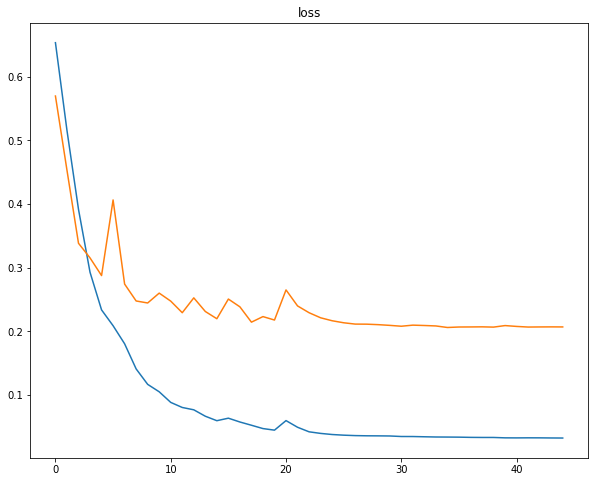

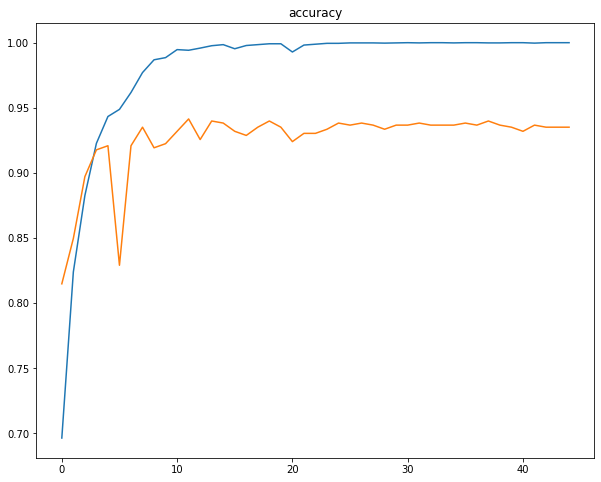

In [11]:
plot_train_log(train_log_cnn.history)

In [47]:
prediction = model.predict(X_test)
prediction = [1 if x >=0.5 else 0 for x in prediction]

model_eval(prediction,y_test)

	Confusion Matrix
------------------------------
	   Predict
            "1" |  "0"
Actual "1"| 277 | 29
       "0"| 25  | 277
------------------------------

accuracy =  0.9111842105263158
precision =  0.9172185430463576
recall =  0.9052287581699346
F1 =  0.9111842105263158


(277, 25, 29, 277)

In [48]:
model.evaluate(X_test,y_test)

19/19 [==============================] - 1s 66ms/step - loss: 0.2615 - accuracy: 0.9112


[0.2614883780479431, 0.9111841917037964]

In [34]:
cnn_best = load_model('./models/cnn.hdf5')

p = cnn_best.predict(X_test)
p = [1 if x >= 0.5 else 0 for x in p]

model_eval(p,y_test)

	Confusion Matrix
------------------------------
	   Predict
            "1" |  "0"
Actual "1"| 97 | 3
       "0"| 15  | 85
------------------------------

accuracy =  0.91
precision =  0.8660714285714286
recall =  0.97
F1 =  0.9150943396226415


(97, 15, 3, 85)

## MLP 

In [10]:
model_mlp = Sequential()

model_mlp.add(Flatten(input_shape=(150,150,3)))
model_mlp.add(Dense(512,activation="relu"))
model_mlp.add(Dense(256,activation="relu"))
model_mlp.add(Dense(128,activation="relu"))
model_mlp.add(Dense(128,activation="relu"))
model_mlp.add(Dense(256,activation="relu"))
model_mlp.add(Dense(64,activation="relu"))
model_mlp.add(Dense(128,activation="relu"))
model_mlp.add(Dense(64,activation="relu"))
model_mlp.add(Dense(128,activation="relu"))
model_mlp.add(Dense(64,activation="relu"))
model_mlp.add(Dense(1, activation="sigmoid"))

model_mlp.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 67500)             0         
_________________________________________________________________
dense_11 (Dense)             (None, 512)               34560512  
_________________________________________________________________
dense_12 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_13 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_14 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_15 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_16 (Dense)             (None, 64)               

In [11]:
save_name = 'mlp.hdf5'

early_stopping = EarlyStopping(monitor='val_loss',
                              patience=10,
                              verbose=0,
                              mode='auto')
model_save = ModelCheckpoint('./models/'+ save_name,
                             save_best_only=True,
                             monitor='val_loss',
                             mode='min')

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.1,
                              patience=5,
                              verbose=1,
                              min_delta=1e-4,
                              mode='min')

In [12]:
model_mlp.compile(loss='binary_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])

train_log_mlp = model_mlp.fit(X_train,y_train,
                          batch_size=128,
                          epochs=27,
                          validation_data=(X_val, y_val),
                         callbacks=[early_stopping, model_save, reduce_lr])

# model_mlp.save('./models/mlp.hdf5')
hist = train_log_mlp.history.copy()
del hist['lr']
with open('mlp_log.json', 'w') as f:
    json.dump(hist, f)

Epoch 1/27
47/47 [==============================] - 10s 201ms/step - loss: 0.8752 - accuracy: 0.5151 - val_loss: 0.6268 - val_accuracy: 0.6440
Epoch 2/27
47/47 [==============================] - 9s 192ms/step - loss: 0.6393 - accuracy: 0.6477 - val_loss: 0.5500 - val_accuracy: 0.6915
Epoch 3/27
47/47 [==============================] - 8s 180ms/step - loss: 0.5958 - accuracy: 0.6913 - val_loss: 0.5243 - val_accuracy: 0.7278
Epoch 4/27
47/47 [==============================] - 9s 182ms/step - loss: 0.5556 - accuracy: 0.7121 - val_loss: 0.5369 - val_accuracy: 0.7310
Epoch 5/27
47/47 [==============================] - 9s 185ms/step - loss: 0.5215 - accuracy: 0.7284 - val_loss: 0.5596 - val_accuracy: 0.7089
Epoch 6/27
47/47 [==============================] - 9s 182ms/step - loss: 0.5321 - accuracy: 0.7232 - val_loss: 0.5501 - val_accuracy: 0.7326
Epoch 7/27
47/47 [==============================] - 8s 179ms/step - loss: 0.5087 - accuracy: 0.7505 - val_loss: 0.5580 - val_accuracy: 0.7294
Epoch

In [51]:
model_mlp.evaluate(X_test,y_test)

19/19 [==============================] - 1s 37ms/step - loss: 0.6094 - accuracy: 0.6875


[0.6093984246253967, 0.6875]

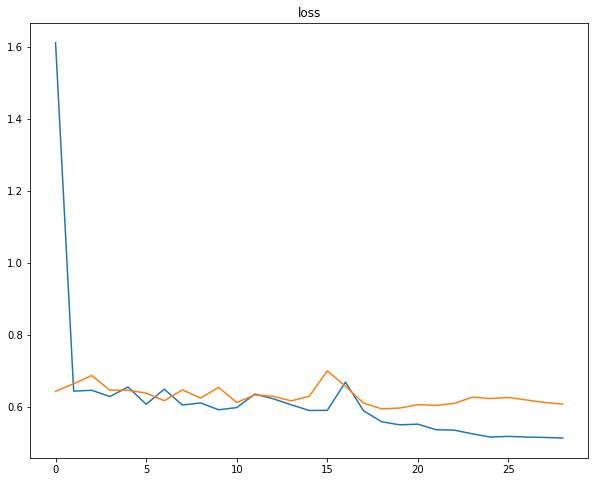

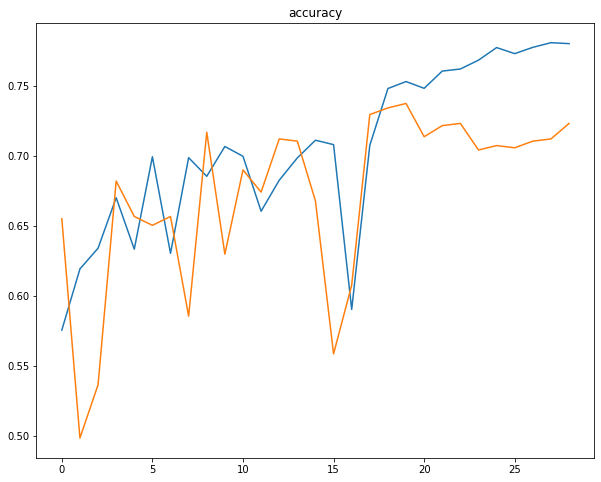

In [52]:
plot_train_log(train_log_mlp.history)

In [53]:
prediction_mlp = model_mlp.predict(X_test)
prediction_mlp = [1 if x >= 0.5 else 0 for x in prediction_mlp]
model_eval(prediction_mlp, y_test)

	Confusion Matrix
------------------------------
	   Predict
            "1" |  "0"
Actual "1"| 163 | 143
       "0"| 47  | 255
------------------------------

accuracy =  0.6875
precision =  0.7761904761904762
recall =  0.5326797385620915
F1 =  0.6317829457364341


(163, 47, 143, 255)